In [186]:
import pandas as pd
import geopandas as gpd
import numpy as np
from access import Access, weights, Datasets
from typing import List
import os
from pathlib import Path
import pickle
import re
import shapely
from tqdm import tqdm
pd.options.mode.chained_assignment = None

# TODO:
- [x] Load OD pairs for each graph
- [x] Load *cleaned* group data for the respective year
- [x] Load Amsterdam Buurten map
- [x] Join group data with Buurten map
- [ ] Compute threshold COM per group per graph
- [ ] Define social equity measure
- [ ] Compute Theil inequality index

# Data Preparation

In [151]:
OD_MAT_DIR = Path("/home/rico/Documents/thesis/eda/notebooks/tmp")
AMS_DATA_BASE_DIR = Path("/home/rico/Documents/thesis/eda/data/Amsterdam/")

In [152]:
od_mats = [OD_MAT_DIR.joinpath(file) for file in os.listdir(OD_MAT_DIR) if Path(file).suffix == '.pkl']
od_mats_2019 = [od_mat_path for od_mat_path in od_mats if '2019' in od_mat_path.name]
od_mats_2020 = [od_mat_path for od_mat_path in od_mats if '2020' in od_mat_path.name]
od_mats_2021 = [od_mat_path for od_mat_path in od_mats if '2021' in od_mat_path.name]
print(f"Obtained number of OD Matrices: 2019 - {len(od_mats_2019)}, 2020 - {len(od_mats_2020)}, 2021 - {len(od_mats_2021)}")

Obtained number of OD Matrices: 2019 - 52, 2020 - 52, 2021 - 52


In [153]:
destinations = gpd.read_file("/home/rico/Documents/thesis/eda/data/Amsterdam/non_residential_functions_geojson_latlng.json")
cat_to_exclude = ['Wonen', 'Coffeeshop', 'Prostitutie', 'Logies']
destinations = destinations[~destinations.Functie.isin(cat_to_exclude)]
education = destinations[destinations.Functie == 'Onderwijs']
education.geometry = gpd.points_from_xy(education.geometry.y, education.geometry.x, crs='EPSG:4326')

In [230]:
CLEANED_AMS_NHS_DIR = AMS_DATA_BASE_DIR.joinpath('cleaned_neighbourhood_data/')

def load_geometry_fields(gdf: gpd.GeoDataFrame, fields: List[str]):
    for field in fields:
        gdf[field] = gdf[field].apply(shapely.wkt.loads)
    return gdf

kwb_19_ams_neighborhoods = gpd.read_parquet(CLEANED_AMS_NHS_DIR.joinpath('kwb_19_ams_neighborhood.parquet'))
kwb_20_ams_neighborhoods = gpd.read_parquet(CLEANED_AMS_NHS_DIR.joinpath('kwb_20_ams_neighborhood.parquet'))
kwb_21_ams_neighborhoods = gpd.read_parquet(CLEANED_AMS_NHS_DIR.joinpath('kwb_21_ams_neighborhood.parquet'))

# kwb_19_ams_neighborhoods = load_geometry_fields(kwb_19_ams_neighborhoods, ['geometry', 'centroid', 'res_centroid'])
# kwb_20_ams_neighborhoods = load_geometry_fields(kwb_20_ams_neighborhoods, ['geometry', 'centroid', 'res_centroid'])
# kwb_21_ams_neighborhoods = load_geometry_fields(kwb_21_ams_neighborhoods, ['geometry', 'centroid', 'res_centroid'])

assert kwb_19_ams_neighborhoods.columns.tolist() == kwb_20_ams_neighborhoods.columns.tolist() == kwb_21_ams_neighborhoods.columns.tolist()

# Social Equity Definition
## What groups are we looking at?
This depends on the type of opportunity we are looking at. Our current investigation is for education. Hence, we will be looking at `a_w_all` and `a_nw_all`, i.e. western vs. non-western pop. respectively, as well as `a_00_14` and `a_15_24` which are age groups from 0-14 and 15-25 years respectively. From the percentage of western/non-western population in a specific region, we then get a distribution that we assume to be similar on the age groups. That way we can not only identify western vs. non-western but also western vs. non-western in the relevant age-span.

We furthermore look at the income per capita:

# Equity Computation

In [ ]:
def compute_metric_per_group(od_matrix: np.array, group_df: gpd.GeoDataFrame, groups: List[str]) -> pd.DataFrame:
    pass

In [234]:
# Percent westerners
western = kwb_19_ams_neighborhoods[['BU_NAAM', 'a_w_all', 'a_inw']]
western['p_w'] = western['a_w_all'] / western['a_inw']
western = western.drop(columns=['a_w_all', 'a_inw'])

# Percent non-westerners
non_western = kwb_19_ams_neighborhoods[['BU_NAAM', 'a_nw_all', 'a_inw']]
non_western['p_nw'] = non_western['a_nw_all'] / non_western['a_inw']
non_western = non_western.drop(columns=['a_nw_all', 'a_inw'])

# Percent inhabitants to be schooled
to_school = kwb_19_ams_neighborhoods[['BU_NAAM', 'a_00_14', 'a_15_24', 'a_inw']]
to_school['a_00_24'] = to_school['a_00_14'] + to_school['a_15_24']
to_school['p_00_24'] = to_school['a_00_24'] / to_school['a_inw']
to_school = to_school.drop(columns=['a_00_14', 'a_15_24', 'a_inw', 'a_00_24'])

# Percent households with kids
hh_with_kids = kwb_19_ams_neighborhoods[['BU_NAAM', 'a_hh_m_k', 'a_hh']]
hh_with_kids['p_hh_m_k'] = hh_with_kids['a_hh_m_k'] / hh_with_kids['a_hh']
hh_with_kids = hh_with_kids.drop(columns=['a_hh_m_k', 'a_hh'])

# Percent of households in the Netherland's lowest 40% of income
lowest_40p_income_hh = kwb_19_ams_neighborhoods[['BU_NAAM', 'p_hh_li']]

<AxesSubplot:>

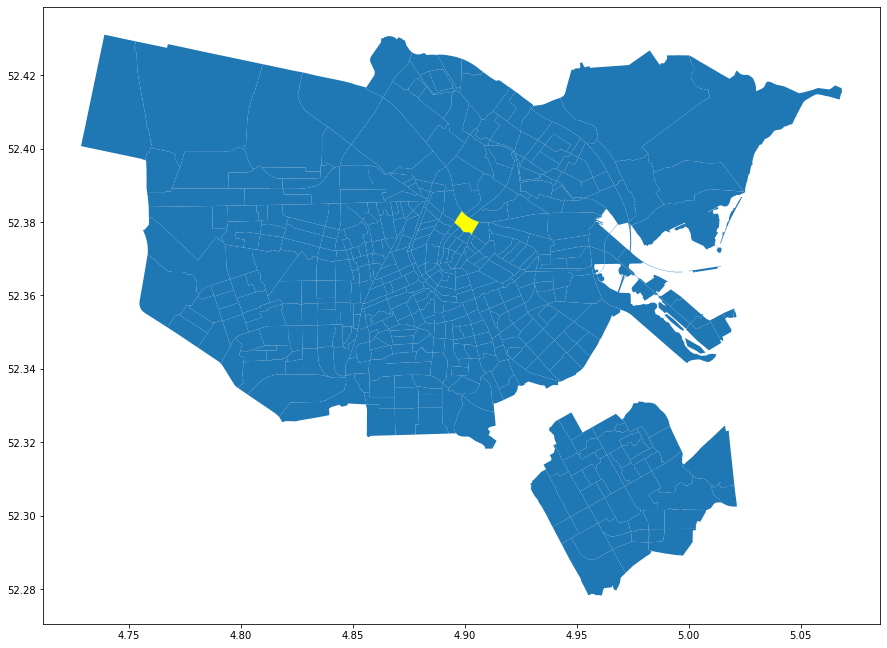

In [253]:
base = kwb_19_ams_neighborhoods.plot(figsize=(15,15))
kwb_19_ams_neighborhoods[kwb_19_ams_neighborhoods==kwb_19_ams_neighborhoods.iloc[5]].plot(ax = base, color='yellow')

In [184]:
months = {i: {} for i in range(1,13)}
loaded_od_mats = {2019: months, 2020: months, 2021: months}

for od_mat in od_mats:
    with open(od_mat, 'rb') as fp:
        # tt_mx, td_mx, modes_mx, lines_mx, hops_mx, failed
        tt_mx, td_mx, modes_mx, lines_mx, hops_mx, _ = pickle.load(fp)
    od_mat_date = re.findall('\d+',od_mat.name)[0]
    year = int(od_mat_date[:4])
    month = int(od_mat_date[4:6])
    day = int(od_mat_date[6:])

KeyboardInterrupt: 